# Applying Machine Learning Corrections to APDFT Predicted Adsorbate Binding Energies

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.svm import SVR
from dict_def import *

## Here is an example of the data file used in this analysis

In [40]:
df = pd.read_csv('data/111-Pt-1x1-C-bridge.csv')
df.head()

,Unnamed: 0,label,delta nuclear charge,transmute indexes,transmute espdiff,counter indexes,counter espdiff,alchemical derivative,slab atoms object,ads atoms object,deltaE DFT,absolute errors
0,0,0.0.Au3.Ir0,1,[3],[-1.3250000000000028],[0],[0.2704000000000093],-1.5954,"Atoms(symbols='IrPt2Au', pbc=True, cell=[[2.77...","Atoms(symbols='IrPt2AuC', pbc=True, cell=[[2.7...",-1.636731,0.041331
1,1,0.1.Au2.Ir0,1,[2],[0.39879999999999427],[0],[0.2704000000000093],0.1284,"Atoms(symbols='IrPtAuPt', pbc=True, cell=[[2.7...","Atoms(symbols='IrPtAuPtC', pbc=True, cell=[[2....",0.026809,0.101591
2,0,0.0.Ir3.Au0,-1,[3],[-1.3250000000000028],[0],[0.2704000000000093],1.5954,"Atoms(symbols='AuPt2Ir', pbc=True, cell=[[2.77...","Atoms(symbols='AuPt2IrC', pbc=True, cell=[[2.7...",1.184894,0.410506
3,1,0.1.Ir2.Au0,-1,[2],[0.39879999999999427],[0],[0.2704000000000093],-0.1284,"Atoms(symbols='AuPtIrPt', pbc=True, cell=[[2.7...","Atoms(symbols='AuPtIrPtC', pbc=True, cell=[[2....",-0.269154,0.140754
4,0,0.0.Au3.Au2.Ir0.Ir1,1,"[3, 2]","[-1.3250000000000028, 0.39879999999999427]","[0, 1]","[0.2704000000000093, 0.35590000000000543]",-1.5525,"Atoms(symbols='Ir2Au2', pbc=True, cell=[[2.771...","Atoms(symbols='Ir2Au2C', pbc=True, cell=[[2.77...",-1.716646,0.164146


## Cleaning and organizing the data

### Reformatting columns that contain information about the sites transmuted when creating hypothetical alloys.

In [41]:
def reformat_transmute_id(x):
    
    id_string = ''
    X = x.strip('[]').split(', ') # Remove brackets ([]) and split comma seperated values
    
    for n in X:
        id_string += n + ':' # Store colon seperated values
        
    return id_string[:-1]

### Changes the indices of transmuted sites to values that are more interpretable

In [42]:
def normalize_transmutation_index(x,coverage):
    '''
    Re-labels transmutation sites that are read from the CSV file.
    '''
    
    X = x.split(':') #Splits colon seperated values 
    
    if coverage == '1x1':
        
        index_dict = {3:0, 2:9} #Dictionary that maps site labels in a 1x1 surface slab
        
    else:
        
        index_dict = {12:0, 13:1, 14:3, 15:4,
                      8:9, 9:10, 10:12, 11:13} #Dictionary that maps site labels in a 2x2 or 3x3 surface slab
    
    index_string = ''
    for n in X:
        
        index_string += str(index_dict[int(n)]) + ':' #Redefining site labels and writing a colon seperated list
    
    return index_string[:-1]

### Function that puts everything together, reading data files, reformatting and writing new columns, and returning a new dataframe.

In [43]:
def read_file(facet, coverage):
    '''
    Reads a CSV file
    Returns a DataFrame
    '''
    ads_dict = all_surf['{}_{}'.format(facet, coverage)] #Read in a dictionary that corresponds to facet and coverage from dict_def.py
    df = pd.DataFrame()
    for ads, site in ads_dict.items():
        read_df = pd.read_csv('data/{}-Pt-{}-{}-{}.csv'.format(facet, coverage, ads, site)) #Read every CSV in data directory that matches items in ads_dict
        
        #Writing the DataFrame
        if coverage == '1x1' or coverage == '2x2': # read_df is stored into ads_df the same way for CSVs for 1x1 and 2x2 surface slabs
            
            for col in ['transmute indexes', 'transmute espdiff', 'counter indexes', 'counter espdiff']:
                read_df[col] = read_df[col].apply(reformat_transmute_id)
                
            read_df['transmute indexes'] = read_df['transmute indexes'].apply(normalize_transmutation_index, coverage=coverage)
        
            ads_df = pd.DataFrame({'molid': read_df['label'],
                               'deltaz': read_df['delta nuclear charge'],
                               'inert': read_df['counter indexes'],
                               'active': read_df['transmute indexes'],
                               'delBE_dft': read_df['deltaE DFT'],
                               'delBE_alc': read_df['alchemical derivative'],
                               'ads': ads,
                               'site': site,
                               'fac': facet,
                               'cov': coverage})
            
        else: # read_df is stored into ads_df differently for 3x3 surface slabs
            
            ads_df = pd.DataFrame({'molid': read_df['molid'],
                               'deltaz': read_df['deltaz'],
                               'inert': read_df['inert'],
                               'active': read_df['active'],
                               'delBE_dft': read_df['delBE_dft'],
                               'delBE_alc': read_df['delBE_alc'],
                               'ads': ads,
                               'site': site,
                               'fac': facet,
                               'cov': coverage})

        df = pd.concat([df, ads_df])
    return df

### Here is an example of the new dataframe that is returned.

In [44]:
read_file('111','3x3')

,molid,deltaz,inert,active,delBE_dft,delBE_alc,ads,site,fac,cov
0,0_Au-2_Ir,1,0,2,0.055170,0.0808,O,fcc,111,3x3
1,0.2_Hg-0.4_Os,2,0:2,0:4,0.527246,1.0384,O,fcc,111,3x3
2,2_Hg-4_Os,2,2,4,-0.076104,-0.0142,O,fcc,111,3x3
3,4_Os-0_Hg,2,4,0,-0.874373,-1.0470,O,fcc,111,3x3
4,0.2_Ir-0.2_Au,1,0:2,0:2,-0.565983,-0.6196,O,fcc,111,3x3
...,...,...,...,...,...,...,...,...,...,...
190,0.1.4_Au-0.1.7_Ir,1,0:1:4,0:1:7,0.121329,0.3556,CH3,ontop,111,3x3
191,0_Hg-5_Os,2,0,5,0.043877,0.0942,CH3,ontop,111,3x3
192,0.1.4_Re-0.5.7_Tl,3,0:1:4,0:5:7,-1.794876,-1.0743,CH3,ontop,111,3x3
193,1_Os-3_Hg,2,1,3,-0.052110,-0.0502,CH3,ontop,111,3x3


## Building features

### This function sets a binary indication of a site being transmuted

In [45]:
def enc(x, val):
    '''
    Encodes the site fingerprint vector
    '''
    xs = [int(i) for i in x.split(':')]
    found = 0
    for i in xs:
        if i == val:
            found = 1
    return found

### Writes a new dataframe with more columns that give binary indications of features that describe an alloy+adsorbate system 

In [46]:
def make_features(ads_list):
    fac = ['111'] #available facets in data directory
    cov = ['1x1','2x2','3x3'] #available coverages in data directory
    df = pd.DataFrame()
    for f in fac:
        for c in cov:
            fac_df = read_file(f, c) #read all availabe CSV files for given facets and coverages
            df = pd.concat([df, fac_df])
    df = df.reset_index()
    
    df['absE'] = abs(df['delBE_dft'] - df['delBE_alc']) #calculating absolute errors
    df['Error'] = (df['delBE_dft'] - df['delBE_alc']) #calculating errors
    df['nchanges'] = df['inert'].apply(lambda x: len(str(x).split(':'))) #Counting the number of transmutations
    
    #Identifying the species of the transmuted site
    for c in cov:
        
        if c == '3x3':
            
            df.loc[df['cov'] == c,'asol'] = df.loc[df['cov'] == c,'molid'].apply(lambda x:x[-2:])
            
        else:
            
            df.loc[df['cov'] == c,'asol'] = df.loc[df['cov'] == c,'molid'].apply(lambda x:x.split('.')[2][:2])

    #Filtering out alloy entries with adsorbates that match adsorbates in ads_list and putting into df2
    df2 = df[df['ads'].isin(ads_list)]
    df2.loc[:,'ads_trans'] = df2.loc[:,'ads']
    df2.loc[:,'cov_trans'] = df2.loc[:,'cov']
    
    #Finding unique transmutation sites
    asite_set = set()
    for d in df2['active']:
        ds = d.split(':')
        asite_set.update(ds)

    #Encoding alloy entries by labelling transmuted sites with 1's
    for s in asite_set:
        df2.loc[:,'a_{}'.format(s)] = df2['active'].map(lambda x: enc(x, int(s)))
    
    #Defining feature columns    
    asite_cols = ['a_{}'.format(i) for i in asite_set]
    ads_cols = ['ads_{}'.format(s) for s in df2['ads'].unique()]
    asol_cols = ['asol_{}'.format(s) for s in df2['asol'].unique()]
    cov_cols = ['cov_{}'.format(s) for s in df2['cov'].unique()]
    enc_cols = ads_cols  + asite_cols + asol_cols + cov_cols

    df2 = pd.get_dummies(df2, columns = ['ads','asol','cov'])
    features = enc_cols + ['nchanges', 'deltaz']
    
    return df2, features

### Making features for datasets that include adsorbates contained in `adsorbate_list`

In [47]:
adsorbate_list = ['O','OH','OH2','OOH']
df, features = make_features(adsorbate_list)

C:\Users\CDG36\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\CDG36\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Here is the final dataframe

In [48]:
df

,index,molid,deltaz,inert,active,delBE_dft,delBE_alc,site,fac,absE,...,ads_OOH,asol_Au,asol_Hg,asol_Ir,asol_Os,asol_Re,asol_Tl,cov_1x1,cov_2x2,cov_3x3
36,0,0.0.Au3.Ir0,1,0,0,-1.617295,-1.6567,ontop,111,0.039405,...,0,1,0,0,0,0,0,1,0,0
37,1,0.1.Au2.Ir0,1,0,9,-0.308847,-0.1850,ontop,111,0.123847,...,0,1,0,0,0,0,0,1,0,0
38,2,0.0.Ir3.Au0,-1,0,0,1.394001,1.6567,ontop,111,0.262699,...,0,0,0,1,0,0,0,1,0,0
39,3,0.1.Ir2.Au0,-1,0,9,0.074022,0.1850,ontop,111,0.110978,...,0,0,0,1,0,0,0,1,0,0
40,4,0.0.Au3.Au2.Ir0.Ir1,1,0:1,0:9,-1.852192,-1.8123,ontop,111,0.039892,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14652,204,4_Ir-0_Au,1,4,0,-0.072262,-0.1162,ontop,111,0.043938,...,0,1,0,0,0,0,0,0,0,1
14653,205,0.4.8_Os-0.1.4_Hg,2,0:4:8,0:1:4,-0.089943,-0.2722,ontop,111,0.182257,...,0,0,1,0,0,0,0,0,0,1
14654,206,0.4_Au-1.3_Ir,1,0:4,1:3,-0.035553,-0.0307,ontop,111,0.004853,...,0,0,0,1,0,0,0,0,0,1
14655,207,0.4_Hg-3.4_Os,2,0:4,3:4,-0.055922,-0.0282,ontop,111,0.027722,...,0,0,0,0,1,0,0,0,0,1


#### Here are the feature vectors that will be fed into machine learning models

In [49]:
df[features]

,ads_O,ads_OH2,ads_OH,ads_OOH,a_3,a_2,a_7,a_0,a_5,a_10,...,asol_Ir,asol_Hg,asol_Os,asol_Tl,asol_Re,cov_1x1,cov_2x2,cov_3x3,nchanges,deltaz
36,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
37,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
38,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,1,-1
39,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,-1
40,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14652,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,1
14653,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,3,2
14654,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,2,1
14655,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,2,2


## Training models, making predictions, and visualizing results.

### Makes parity plots that compare APDFT vs DFT before and after machine learning corrections

In [50]:
def make_figure(f,df2,title):
    '''
    Parity figure plotter
    '''
    xlow, xhigh = df2['delBE_dft'].min(), df2['delBE_dft'].max()
    ylow, yhigh = df2[f].min(), df2[f].max()
    #low = min(np.ceil(xlow), np.ceil(xhigh), np.floor(ylow), np.ceil(yhigh))
    low = -8
    #high = max(np.ceil(xlow), np.ceil(xhigh), np.floor(ylow), np.ceil(yhigh))
    high = 8
    sns.set(style='white',font_scale=1.5)
    g = sns.FacetGrid(df2, hue='ads_trans', height=4, aspect=1)
    g = g.map(plt.scatter, 'delBE_dft', f, edgecolor="k", marker='o')
    g.add_legend()
    print(type(g))
    #g.set(ylim=(low,high), xlim=(low,high), xticks=range(int(low),int(high),1), yticks=range(int(low),int(high),1))
    plt.plot(np.arange(low,high),np.arange(low,high), color='k')
    plt.xlim(low, high)
    plt.ylim(low, high)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()
    plt.title(title)

### Training support vector regression models with the new dataframe and features, predicting corrections, and applying them to APDFT predicted binding energies

In [51]:
# Train-test split and fitting model to training data
def train_and_predict(df, features, ads):
    target = df['Error']
    df = df.drop('Error',axis=1)
    df_X, df_X_test, df_y, df_y_test = train_test_split(df, target, test_size=0.2, random_state=200)

    y = df_y
    X = df_X[features]

    k_fold = KFold(n_splits=10)
    reg = SVR(kernel='rbf', C=1e3, gamma=0.1)
    scores = cross_val_score(reg, X, y, cv=k_fold, scoring='neg_mean_absolute_error')
    print('Mean: ', np.mean(scores))

    reg.fit(X,y)

    # Validating performance of trained model on test data
    X_test = df_X_test[features]
    y_pred = reg.predict(X_test)

    # Adding predicted errors to delBE_alc
    df_X_test = df_X_test.reset_index()
    yp_df = pd.Series(y_pred, name='y_pred')
    df_X_test = pd.concat([df_X_test, yp_df], axis =1)
    df_X_test = pd.concat([df_X_test, df_y_test.reset_index().drop('index',axis=1)], axis =1)
    df_X_test['delBE_alc_ml'] = df_X_test['delBE_alc'] + df_X_test['y_pred']

    print('MAE(with ML correction):{} eV'.format(mean_absolute_error(df_X_test['delBE_dft'], df_X_test['delBE_alc_ml'])))
    print('MAE(no ML correction):{} eV'.format(mean_absolute_error(df_X_test['delBE_dft'], df_X_test['delBE_alc'])))
    make_figure('delBE_alc', df_X_test, ads)
    make_figure('delBE_alc_ml', df_X_test, ads+'_ML')
    
    return df_X, df_X_test, df_y, df_y_test

### Here is an example of the OHx dataset used as input for this function

Mean:  -0.06830195165409152
MAE(with ML correction):0.0643488599488897 eV
MAE(no ML correction):0.39086477256304086 eV
<class 'seaborn.axisgrid.FacetGrid'>
<class 'seaborn.axisgrid.FacetGrid'>


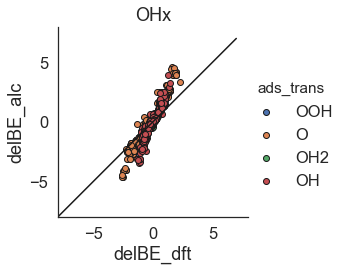

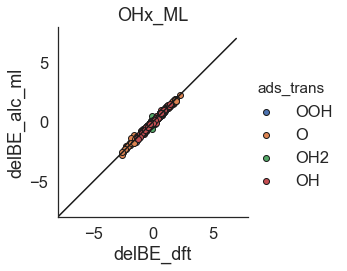

In [52]:
df_X, df_X_test, df_y, df_y_test = train_and_predict(df, features, 'OHx')